In [1]:
# Import libraries to aid your analysis
import pandas as pd #pandas places one's data in a tables format
from bokeh.plotting import figure, output_notebook, show #builds interactive graphs for python
from bokeh.models import Range1d
import math #this is used in graphic section to use the irrational number pi
output_notebook() #Allows inline plotting for Juptyer notebook

Loading BokehJS ...

In [2]:
#Imports necessary aspects of Bokeh for plotting on a map
from bokeh.tile_providers import get_provider, Vendors
from pyproj import Transformer
tile_provider = get_provider('STAMEN_TERRAIN')

In [3]:
from osgeo import gdal
from osgeo import ogr
import numpy as np
import os
from bokeh.io import output_file

In [4]:
#import landscan data
file = '/Users/samanthagolden/Desktop/lspop2018/lspop18.tif'

In [5]:
#define output tif for masked raster file
out_tif = '/Users/samanthagolden/Desktop/lspop2018/lspop18maskedniger.tif'

In [6]:
landscan = gdal.Open(file)

In [7]:
print(landscan.RasterXSize)

43200


In [8]:
#create pyproj transformer to convert form lat/long to web mercator
#transformer = Transformer.from_crs('epsg:4326','epsg:3857')

In [9]:
#pts = [(11.012813,-0.925226), (23.281719,16.106159)]
#bbox = []
#for pt in transformer.itransform(pts): 
   #bbox.append(pt)

In [10]:
#Plots the bounding box
#p = figure(x_range=(bbox[0][0], bbox[1][0]),y_range=(bbox[0][1], bbox[1][1]),x_axis_type="mercator", y_axis_type="mercator")
#add the map form the Bokeh map vendor in this case Stamen_Terrain --- see documentation
#p.add_tile(tile_provider)

#shows the plot
#show(p)

In [11]:
#ds = gdal.Open('/Users/samanthagolden/Desktop/lspop2018/lspop18.tif')
#ds = gdal.Translate('new.tif', ds, format = 'GTiff', projWin = [11.012813, -0.925226, 23.281719, 16.106159])
#ds = None

In [12]:
#gdalinfo [-stats] /Users/samanthagolden/Desktop/lspop2018/lspop18.tif

In [13]:
#read the landscan tif data with gdal
#arraydata = landscan.ReadAsArray()

In [14]:
#And then pass it on the your favourite plotting library.Alternatively you could simply output 
#to a more common 'picture' format (PNG for example), and use any viewer you like to display the result.

#vmin = -10 # minimum value in your data (will be black in the output)
#vmax = 10 # maximum value in your data (will be white in the output)
ds = gdal.Translate('landscan.png', '/Users/samanthagolden/Desktop/lspop2018/lspop18.tif', format='PNG', outputType=gdal.GDT_Byte)
ds = None

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/bokeh/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['show', 'figure']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


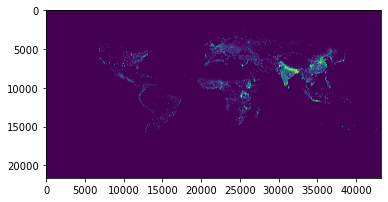

In [15]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('landscan.png')
imgplot = plt.imshow(img)
plt.show()

In [16]:
import rasterio
from matplotlib import pyplot
landscanrast = rasterio.open('/Users/samanthagolden/Desktop/lspop2018/lspop18.tif')


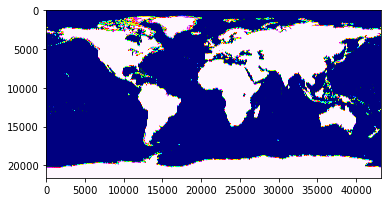

In [17]:
pyplot.imshow(landscanrast.read(1,), cmap = 'gist_ncar')
pyplot.show()

In [18]:
rasterio.coords.BoundingBox(11.012813, -0.925226, 23.281719, 16.106159)

BoundingBox(left=11.012813, bottom=-0.925226, right=23.281719, top=16.106159)

In [19]:
landscanrast.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999999858, top=89.99999999999929)

In [20]:
landscanrast.count

1

In [21]:
landscanrast.crs.data

{'init': 'epsg:4326'}

In [22]:
from shapely.geometry import box
minx, miny = 11.012813, -0.925226

maxx, maxy = 23.281719, 16.106159

bbox = box(minx, miny, maxx, maxy)

In [23]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

In [24]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

/opt/anaconda3/envs/bokeh/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [25]:
geo = geo.to_crs(crs=landscanrast.crs.data)

In [26]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [27]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[23.281719, -0.925226], [23.281719, 16.106159], [11.012813, 16.106159], [11.012813, -0.925226], [23.281719, -0.925226]]]}]


In [28]:
out_img, out_transform = mask(dataset=landscanrast, shapes=coords, crop=True)

In [29]:
out_meta = landscanrast.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0083333333333333, 0.0, -180.0,
       0.0, -0.0083333333333333, 89.99999999999929)}


In [30]:
epsg_code = int(landscanrast.crs.data['init'][5:])
print(epsg_code)

4326


In [31]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 'nodata': -2147483647.0,
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(4326).to_proj4()})

In [32]:
with rasterio.open(out_tif, "w", **out_meta) as dest: 
    dest.write(out_img)

In [33]:
 clipped = rasterio.open(out_tif)

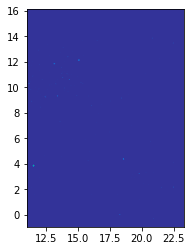

<AxesSubplot:>

In [34]:
show((clipped, 1), cmap = 'terrain')

In [ ]:
from zipfile import ZipFile 

In [ ]:
landscan18 = '/Users/samanthagolden/Desktop/lspop2018/hdr.adf'

In [ ]:
with ZipFile(landscan18, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 

In [ ]:
pop18 = gdal.Open(landscan18)

In [ ]:
pop18rast = rasterio.open(r'/Users/samanthagolden/Desktop/lspop2018/hdr.adf')
pyplot.imshow(pop18rast.read(1), cmap='terrain')
pyplot.show()